## Download the dataset from kaggle

In [ ]:
import kagglehub
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")
print(path)

## Importing the required libraries

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

## Read the dataset and print the priview

In [22]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

print(df)

       gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140        

## Proccessing the data using onehot encoding to convert the categorical data such as gender and smoking_history into a numerical format 

In [109]:
print(df["gender"].unique())

print(df["smoking_history"].unique())

df_onehot_genders = pd.get_dummies(df, columns=["gender"], prefix="gender")
for col in df_onehot_genders:
    if df_onehot_genders[col].dtype == 'bool':
        df_onehot_genders[col] = df_onehot_genders[col].astype(int)
print(df_onehot_genders)

df_onehot_smoking_history = pd.get_dummies(df_onehot_genders, columns=["smoking_history"], prefix="smoker")
for col in df_onehot_smoking_history:
    if df_onehot_smoking_history[col].dtype == 'bool':
        df_onehot_smoking_history[col] = df_onehot_smoking_history[col].astype(int)
print(df_onehot_smoking_history)

df_final = df_onehot_smoking_history
print(df_final)


['Female' 'Male' 'Other']
['never' 'No Info' 'current' 'former' 'ever' 'not current']
        age  hypertension  heart_disease smoking_history    bmi  HbA1c_level  \
0      80.0             0              1           never  25.19          6.6   
1      54.0             0              0         No Info  27.32          6.6   
2      28.0             0              0           never  27.32          5.7   
3      36.0             0              0         current  23.45          5.0   
4      76.0             1              1         current  20.14          4.8   
...     ...           ...            ...             ...    ...          ...   
99995  80.0             0              0         No Info  27.32          6.2   
99996   2.0             0              0         No Info  17.37          6.5   
99997  66.0             0              0          former  27.83          5.7   
99998  24.0             0              0           never  35.42          4.0   
99999  57.0             0         

## Preprocessing the data using StandardScaler to normalize the features (input)

In [66]:
x = df_final[["age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level", "gender_Female", "gender_Male", "gender_Other", "smoker_No Info", "smoker_current", "smoker_ever", "smoker_former", "smoker_never", "smoker_not current"]].values
y = df_final[["diabetes"]].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#print(y_train)


## Defining the model

In [142]:
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        #Layers
        self.l1 = nn.Linear(15, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.l5 = nn.Linear(64, 1)
        #batch normalization Layer
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)
        #Dropout Layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Applying Linear, Batch normalization, ReLU, and Dropout for each layer
        x = torch.relu(self.bn1(self.l1(x)))
        x = self.dropout(x)
        
        x = torch.relu(self.bn2(self.l2(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn3(self.l3(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn4(self.l4(x)))
        x = self.dropout(x)
        
        # Output layer (NOTE : we do not use sigmoid activation function here as we use BCEWithLogitsLoss as loss function which takes care of sigmoid)
        x = self.l5(x)
        return x


## Training the model with BCEWithLogitsLoss as loss function and Adam optimizer with a 1000 epochs

In [143]:
model = DiabetesModel()
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
for epoch in range(epochs):
    predictions = model(x_train)
    loss = loss_function(predictions, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch : [{epoch+1}/{epochs}], Loss : {loss.item():.4f}")
    

Epoch : [100/1000], Loss : 0.1954
Epoch : [200/1000], Loss : 0.1392
Epoch : [300/1000], Loss : 0.1196
Epoch : [400/1000], Loss : 0.1090
Epoch : [500/1000], Loss : 0.1012
Epoch : [600/1000], Loss : 0.0965
Epoch : [700/1000], Loss : 0.0928
Epoch : [800/1000], Loss : 0.0905
Epoch : [900/1000], Loss : 0.0885
Epoch : [1000/1000], Loss : 0.0871


## Setting the model to evaluation mode and making predictions and printing the acutual and predicted values and also calculating the accuracy and precision of the model and saving the results

In [144]:
model.eval()
with torch.no_grad():
    predictions = model(x_test)
    predicted_classes = (torch.sigmoid(predictions) > 0.5).float()

actual = y_test.view(-1).numpy()
predicted = predicted_classes.view(-1).numpy()
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted, pos_label=1)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)

print("Actual:", actual)
print("Predicted:", predicted)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

df_save = pd.DataFrame({
    "actual": actual,
    "predicted": predicted
})

df_save.to_csv('output_diabetes.csv', index=False)

Actual: [0. 0. 0. ... 0. 0. 0.]
Predicted: [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.972
Precision: 1.000
Recall: 0.673
F1-score: 0.805


In [145]:
torch.save(model, 'diabetedModel.pth')

In [146]:
torch.save(model.state_dict(), 'diabetedModelStateDict.pth')

## Confusion Matrix (top-left : The number of non-diabetic cases correctly predicted as non-diabetic), (Top-right : The number of non-diabetic cases incorrectly predicted as diabetic), (Bottom-left : The number of diabetic cases incorrectly predicted as non-diabetic), (Bottom-right : The number of diabetic cases correctly predicted as diabetic)

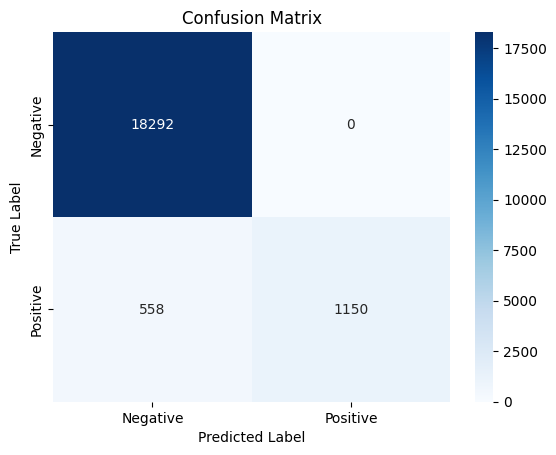

In [147]:
cm = confusion_matrix(y_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## The ROC Curve shows how well the model can tell the difference between diabetic and non-diabetic cases at various decision points, helping us understand its overall accuracy.

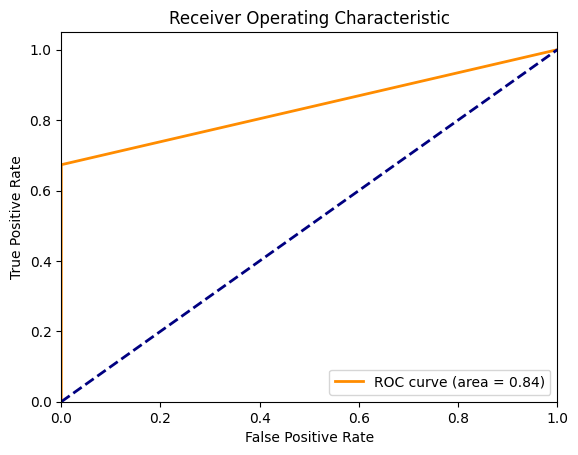

In [148]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, predicted_classes)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
